In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
import shutil

!pip install tensorboardcolab
import tensorboardcolab

import sys

Using TensorFlow backend.


In [2]:
from tensorflow.keras.datasets.cifar10 import load_data
(train_x, train_y), (test_x, test_y) = load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
from tensorflow.keras.datasets.cifar10 import load_data
(train_x, train_y), (test_x, test_y) = load_data()

# rank2 -> rank1 
test_y = test_y.reshape(-1)
train_y = train_y.reshape(-1)

# normalization 
train_x, test_x = [x /255. for x in [train_x, test_x]]

In [4]:
# Meta graph load
import_saver = tf.train.import_meta_graph('./drive/My Drive/ResNet/ResNet-12700.meta')

sess = tf.Session()

# Data load
import_saver.restore(sess,'./drive/My Drive/ResNet/ResNet-12700')

# Get default graph
graph_def = tf.get_default_graph()

# Get variable
get_var = graph_def.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

# Get tensor by name
avg_pool = graph_def.get_tensor_by_name('average_pooling2d/AvgPool:0')
top_conv = graph_def.get_tensor_by_name('resnet_4_1/add:0')
place = graph_def.get_tensor_by_name('Placeholder:0')
is_train = graph_def.get_tensor_by_name('is_train:0')
weights = graph_def.get_tensor_by_name('dense/kernel:0')


W0711 11:50:46.954504 140078877796224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [6]:
print(avg_pool)
print(top_conv)
print(weights)

Tensor("average_pooling2d/AvgPool:0", shape=(?, 1, 1, 128), dtype=float32)
Tensor("resnet_4_1/add:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("dense/kernel:0", shape=(128, 10), dtype=float32_ref)


In [5]:
graph_def.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 16) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'resnet_1_1/layer1/conv2d/kernel:0' shape=(3, 3, 16, 16) dtype=float32_ref>,
 <tf.Variable 'resnet_1_1/layer1/bn/beta:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'resnet_1_1/layer1/bn/gamma:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'resnet_1_1/layer2/conv2d/kernel:0' shape=(3, 3, 16, 16) dtype=float32_ref>,
 <tf.Variable 'resnet_1_1/layer2/bn/beta:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'resnet_1_1/layer2/bn/gamma:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'resnet_2_1/layer1/conv2d/kernel:0' shape=(3, 3, 16, 32) dtype=float32_ref>,
 <tf.Variable 'resnet_2_1/layer1/bn/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'resnet_2_1/layer1/bn/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'resnet_2_1/layer2/conv2d/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'resnet_2_1/layer2/bn/beta:0'

In [0]:
#Bi_linear interpolation
resize_image = tf.image.resize_bilinear(top_conv, size = [32,32])

#Matmul을 위해 32,32,128 -> -1,128
resize = tf.reshape(resize_image, (-1, 128))

#Matmul, Output : Class score per pixel
class_map = tf.matmul(resize, weights)

#class갯수
n_class = class_map.get_shape()[-1]

#32,32로 다시 reshape
class_map = tf.reshape(class_map, [32, 32, n_class])

#3번째 class의 class_map
#class_map[:,:,2]

(32, 32, 3)

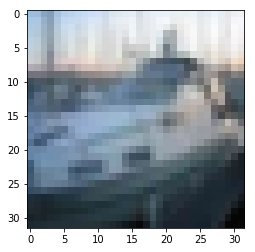

In [7]:
plt.imshow(test_x[2])
test_x[2].shape

(20, 32, 32, 3)


<function matplotlib.pyplot.show>

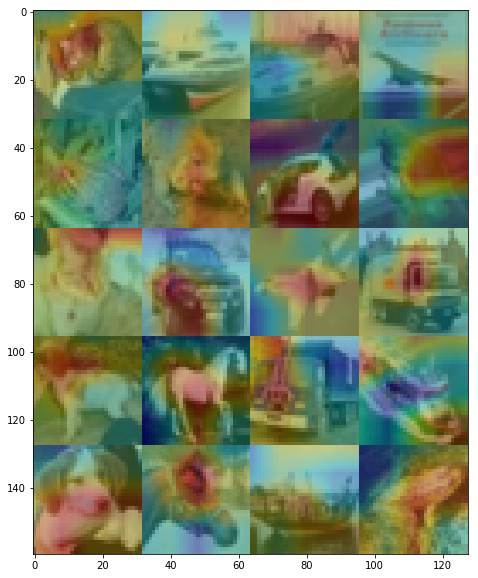

In [8]:
class_stitch = []
for i in range(20) :
    out_class_map = sess.run(class_map, feed_dict = {place : test_x[i:i+1]})
    
    # 정규화 해줘야함
    out_class_map = (out_class_map - out_class_map.min()) / (out_class_map.max() - out_class_map.min())

    # 32(h),32(w),10(class) 중 image의 실제 클래스 추출
    # 학습이 잘 된 모델은 해당 class의 activation score가 make sense할것임
    act_image = out_class_map[:, :, test_y[i]]
    
    ori = test_x[i]
    
    cmap = cv2.applyColorMap(np.uint8(act_image * 255), cv2.COLORMAP_JET)
    cmap = cv2.cvtColor(cmap, cv2.COLOR_BGR2RGB)
    ori = np.uint8(ori*255)
    
    images = cv2.addWeighted(ori, 0.5, cmap, 0.3, 0)
    class_stitch.append(images)
    
    
merged_image = np.stack(class_stitch)
print(merged_image.shape)
merged_image = merged_image.reshape(5,4,32,32,3).transpose([0,2,1,3,4]).reshape([5*32, 4*32, 3])
plt.figure(figsize = (10,10))
plt.imshow(merged_image)
plt.show
